### Домашнее задание 1. Исследовательский вопрос. Парная регрессия. Интерпретация коэффициентов. Предельный эффект и эластичность. Доверительные интервалы

Источники
Часть использованных в семинаре датасетов являются сопровождающими к учебникам D. Gujarati (2009) и Wooldridge (2015). Набор данных про рейтинг преподавателей предоставлен Ф. Картаевым (МГУ).
Задание

Рассмотрите представленные ниже исследовательские ситуации и выполните по каждой из них следующие задания:
* попытайтесь содержательно охарактеризовать проблему, которую хочет решить исследователь (при необходимости сформулируйте исследовательский вопрос, основную гипотезу);
* определите, какая функциональная спецификация модели является наилучшей в данном случае (объясните свой выбор);
* перечислите, какие факторы войдут в ошибку при выбранной спецификации модели;
* загрузите в статистический пакет соответствующий примеру набор данных;
* при необходимости создайте дополнительные переменные и оцените уравнение регрессии;
* проинтерпретируйте полученные оценки коэффициентов регрессии;
* рассчитайте показатели эластичности и предельного эффекта для средних и медианных значений объясняющей переменной; 
* рассчитайте предсказанное моделью значение при среднем и медианном значениях объясняющей переменной; 
* создайте переменные, содержащие в себе значения границ доверительного и предиктивного интервалов (95 %), постройте диаграмму рассеяния и нанесите на нее линию предсказанных значений, а также оба интервала. 

In [1]:
# Initial Set-up
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import linear_model

sns.set_style('whitegrid')

In [2]:
# Defining elasticity and ME for diff. types of models

# Marginal effect for lin log
def me_linlog(beta1, x):
    me = beta1 / np.exp(np.log(x))
    return me

# Elasticity for lin log
def el_linlog(beta0, beta1, x):
    el = beta1 / (np.exp(beta0 + beta1 * np.log(x)))
    return el

# Elsticity for lin lin
def el_linlin(beta0, beta1, x):
    el = (beta1 * x) / (beta0 + beta1 * x)
    return el

# Marginal effect for log log 
def me_loglog(beta0, beta1, x):
    me = beta1 * ((np.exp(beta0 + np.log(x))) / (x))
    return me

# Defining a model type
reg = linear_model.LinearRegression()

In [3]:
# Prediction Interval frame Set-up
from __future__ import division

class LRPI:
    def __init__(self, normalize=False, n_jobs=1, t_value = 2.13144955):
        self.normalize = normalize
        self.n_jobs = n_jobs
        self.LR = linear_model.LinearRegression(normalize=self.normalize, n_jobs= self.n_jobs)
        self.t_value = t_value
        
    def fit(self, X_train, y_train):
        self.X_train = pd.DataFrame(X_train.values)
        self.y_train = pd.DataFrame(y_train.values)
        
        self.LR.fit(self.X_train, self.y_train)
        X_train_fit = self.LR.predict(self.X_train)
        self.MSE = np.power(self.y_train.subtract(X_train_fit), 2).sum(axis=0) / (self.X_train.shape[0] - self.X_train.shape[1] - 1)
        self.X_train.loc[:, 'const_one'] = 1
        self.XTX_inv = np.linalg.inv(np.dot(np.transpose(self.X_train.values) , self.X_train.values))
        
    def predict(self, X_test):
        self.X_test = pd.DataFrame(X_test.values)
        self.pred = self.LR.predict(self.X_test)
        self.X_test.loc[: , 'const_one'] =1
        SE = [np.dot(np.transpose(self.X_test.values[i]) , np.dot(self.XTX_inv, self.X_test.values[i]) ) for i in range(len(self.X_test)) ]
        results = pd.DataFrame(self.pred , columns=['Pred'])
        
        results.loc[:,"lower"] = results['Pred'].subtract((self.t_value)* (np.sqrt(self.MSE.values + np.multiply(SE,self.MSE.values) )),  axis=0)
        results.loc[:,"upper"] = results['Pred'].add((self.t_value)* (np.sqrt(self.MSE.values + np.multiply(SE,self.MSE.values) )),  axis=0)
        
        return results

# # 1
Вам необходимо оценить взаимосвязь между проходным баллом и расходом на студента. Переменная math10 обозначает процент студентов, получивших проходной балл, expend – расходы на студента (набор данных — MEAP93.dta)

In [4]:
df0 = pd.read_stata('MEAP93.DTA')
df0.head(10)

,lnchprg,enroll,staff,expend,salary,benefits,droprate,gradrate,math10,sci11,totcomp,ltotcomp,lexpend,lenroll,lstaff,bensal,lsalary
0,1.4,1862,112.599998,5765,37498.0,7420,2.9,89.199997,56.400002,67.900002,44918.0,10.712594,8.659560,7.529407,4.723842,0.197877,10.532043
1,2.3,11355,101.199997,6601,48722.0,10370,1.3,91.400002,42.700001,65.300003,59092.0,10.986851,8.794976,9.337414,4.617099,0.212840,10.793886
2,2.7,7685,114.000000,6834,44541.0,7313,3.5,91.400002,43.799999,54.299999,51854.0,10.856188,8.829665,8.947025,4.736198,0.164186,10.704165
3,3.4,1148,85.400002,3586,31566.0,5989,3.6,86.599998,25.299999,60.000000,37555.0,10.533562,8.184793,7.045776,4.447346,0.189729,10.359836
4,3.4,1572,96.099998,3847,29781.0,5545,0.0,100.000000,15.300000,65.800003,35326.0,10.472375,8.255049,7.360104,4.565389,0.186193,10.301626
5,3.4,2496,101.099998,5070,36801.0,5895,2.7,89.199997,46.000000,60.500000,42696.0,10.661860,8.531096,7.822445,4.616110,0.160186,10.513280
6,3.6,3358,87.599998,4474,37863.0,6934,1.4,95.099998,33.599998,67.400002,44797.0,10.709896,8.406038,8.119101,4.472781,0.183134,10.541730
7,3.6,11983,96.000000,5159,40133.0,8085,2.5,87.800003,40.099998,69.400002,48218.0,10.783487,8.548498,9.391244,4.564348,0.201455,10.599955
8,4.2,3499,102.800003,5012,36451.0,7253,1.8,93.199997,42.099998,71.699997,43704.0,10.685195,8.519590,8.160233,4.632785,0.198979,10.503724
9,4.2,5095,145.000000,6501,33449.0,7386,1.9,92.099998,39.799999,55.000000,40835.0,10.617295,8.779712,8.536015,4.976734,0.220814,10.417777


In [5]:
# Extract values' labels from stata dataframe's metadata
pd.io.stata.StataReader('MEAP93.dta').variable_labels()

{'lnchprg': 'perc of studs in sch lnch prog',
 'enroll': 'school enrollment',
 'staff': 'staff per 1000 students',
 'expend': 'expend. per stud, $',
 'salary': 'avg. teacher salary, $',
 'benefits': 'avg. teacher benefits, $',
 'droprate': 'school dropout rate, perc',
 'gradrate': 'school graduation rate, perc',
 'math10': 'perc studs passing MEAP math',
 'sci11': 'perc studs passing MEAP science',
 'totcomp': 'salary + benefits',
 'ltotcomp': 'log(totcomp)',
 'lexpend': 'log of expend',
 'lenroll': 'log(enroll)',
 'lstaff': 'log(staff)',
 'bensal': 'benefits/salary',
 'lsalary': 'log(salary)'}

In [6]:
df0 = df0[['math10', 'expend', 'lexpend']]
df0.head(10)

,math10,expend,lexpend
0,56.400002,5765,8.659560
1,42.700001,6601,8.794976
2,43.799999,6834,8.829665
3,25.299999,3586,8.184793
4,15.300000,3847,8.255049
5,46.000000,5070,8.531096
6,33.599998,4474,8.406038
7,40.099998,5159,8.548498
8,42.099998,5012,8.519590
9,39.799999,6501,8.779712


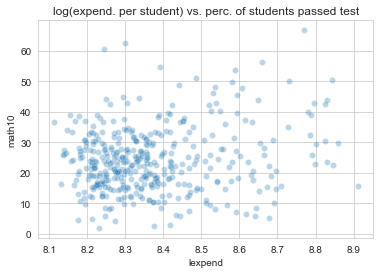

In [7]:
sns.scatterplot(x = df0.lexpend, y = df0.math10, alpha = 0.3)
plt.title('log(expend. per student) vs. perc. of students passed test')
plt.show()

In [8]:
# Split target values into variables 
X = np.array(df0.lexpend).reshape(-1, 1)
y = np.array(df0.math10)
reg.fit(X, y)

LinearRegression()

In [9]:
# Getting values of intercept (beta_0) and slope (beta_1) from our model
intercept, slope = reg.intercept_, float(reg.coef_)
print('beta_0 = {} \nbeta_1 = {}'.format(intercept, slope))

# Evaluating model quality with Coefficient of determination
print('R^2 = {} '.format(reg.score(X, y)))

print('y_hat = {} + {} * x'.format(intercept, slope))

beta_0 = -69.34111022949219 
beta_1 = 11.164395332336426
R^2 = 0.029663267930258863 
y_hat = -69.34111022949219 + 11.164395332336426 * x


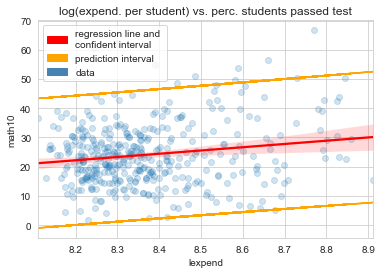

In [10]:
pred_int = LRPI()
pred_int.fit(df0.lexpend, df0.math10)
results = pred_int.predict(df0.lexpend)

plt.title('log(expend. per student) vs. perc. students passed test')
sns.regplot(x = df0.lexpend, y = df0.math10, line_kws = {'color': 'red'}, scatter_kws = {'alpha': 0.2})

red_patch = mpatches.Patch(color = 'red', label = 'regression line and \nconfident interval')
orange_patch = mpatches.Patch(color = 'orange', label = 'prediction interval')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [red_patch, orange_patch, blue_patch])

plt.plot(df0.lexpend, results.lower, color = 'orange')
plt.plot(df0.lexpend, results.upper, color = 'orange')

In [11]:
mean = np.mean(df0.expend)
median = np.median(df0.expend)
print('mean : {}, median : {}'.format(mean, median))

mean : 4376.578431372549, median : 4145.0


In [12]:
# Getting predicted y given mean and median x
pred_mean = reg.predict((np.log(mean)).reshape(-1,1))
print('Predicted value of y for mean X is {}'.format(float(pred_mean)))

pred_median = reg.predict(np.log((median)).reshape(-1,1))
print('Predicted value of y for median X is {}'.format(float(pred_median)))

Predicted value of y for mean X is 24.261431637099548
Predicted value of y for median X is 23.65448542003803


In [13]:
# Computing ME for mean and median x
print('Marginal Effect of mean X is {} '.format(me_linlog(slope, mean)))
print('Marginal Effect of median X is {} '.format(me_linlog(slope, median)))

Marginal Effect of mean X is 0.0025509414505877205 
Marginal Effect of median X is 0.002693460876317593 


In [14]:
# Computing ME for mean and median x
print('Elasticity of mean X is {} '.format(el_linlog(intercept, slope, mean)))
print('Elasticity of median X is {} '.format(el_linlog(intercept, slope, median)))

Elasticity of mean X is 3.2451092580175456e-10 
Elasticity of median X is 5.95419037450206e-10 


# # 2
Исследователь хочет оценить предельную склонность к потреблению на основании наблюдений о сбережениях (savings) и доходе (income), представленных в наборе данных sav_inc.dta.

In [15]:
df1 = pd.read_stata('sav_inc.dta')
df1.head(10)

,observation,savings,income
0,1970,61.000000,727.099976
1,1971,68.599998,790.200012
2,1972,63.599998,855.299988
3,1973,89.599998,965.000000
4,1974,97.599998,1054.199951
5,1975,104.400002,1159.199951
6,1976,96.400002,1273.000000
7,1977,92.500000,1401.400024
8,1978,112.599998,1580.099976
9,1979,130.100006,1769.500000


In [16]:
df1['consumption'] = df1.income - df1.savings
df1.head(10)

,observation,savings,income,consumption
0,1970,61.000000,727.099976,666.099976
1,1971,68.599998,790.200012,721.600037
2,1972,63.599998,855.299988,791.700012
3,1973,89.599998,965.000000,875.400024
4,1974,97.599998,1054.199951,956.599976
5,1975,104.400002,1159.199951,1054.799927
6,1976,96.400002,1273.000000,1176.599976
7,1977,92.500000,1401.400024,1308.900024
8,1978,112.599998,1580.099976,1467.500000
9,1979,130.100006,1769.500000,1639.400024


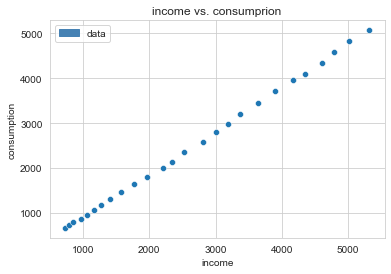

In [17]:
sns.scatterplot(x = df1.income, y = df1.consumption)
plt.title('income vs. consumprion')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [blue_patch])

In [18]:
df1.income.corr(df1.consumption)

0.9997675017585841

In [19]:
X = np.array(df1.income).reshape(-1, 1)
y = np.array(df1.consumption)
reg.fit(X, y)

LinearRegression()

In [20]:
intercept, slope = reg.intercept_, float(reg.coef_)
print('beta_0 = {} \nbeta_1 = {}'.format(intercept, slope))
print('R^2 = {} '.format(reg.score(X, y)))
print('y_hat = {} + {} * x'.format(intercept, slope))

beta_0 = -62.422607421875 
beta_1 = 0.9623209834098816
R^2 = 0.9995350558222347 
y_hat = -62.422607421875 + 0.9623209834098816 * x


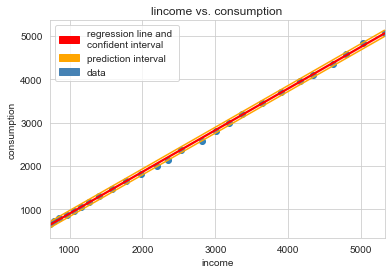

In [21]:
pred_int = LRPI()
pred_int.fit(df1.income, df1.consumption)
results = pred_int.predict(df1.income)

plt.title('lincome vs. consumption')
sns.regplot(x = df1.income, y = df1.consumption, line_kws = {'color': 'red'}, scatter_kws = {'alpha': 0.9})

red_patch = mpatches.Patch(color = 'red', label = 'regression line and \nconfident interval')
yellow_patch = mpatches.Patch(color = 'orange', label = 'prediction interval')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [red_patch, yellow_patch, blue_patch])

plt.plot(df1.income, results.lower, color = 'orange')
plt.plot(df1.income, results.upper, color = 'orange')

plt.savefig('2_2.png', dpi=300)

In [22]:
mean = np.mean(X)
median = np.median(X)

In [23]:
# Computing elasticity for mean and median x
print('Elasticity of mean X is {} '.format(el_linlin(intercept, slope, mean)))
print('Elasticity of median X is {} '.format(el_linlin(intercept, slope, median)))

Elasticity of mean X is 1.0251396829888149 
Elasticity of median X is 1.027370116754139 


#### ME for LinLin - beta_1

In [24]:
pred_mean = reg.predict((mean).reshape(-1,1))
print('Predicted value of y for mean X is {}'.format(float(pred_mean)))

pred_median = reg.predict((median).reshape(-1,1))
print('Predicted value of y for median X is {}'.format(float(pred_median)))

Predicted value of y for mean X is 2483.03076171875
Predicted value of y for median X is 2280.684814453125


# # 3
Исследователь оценивает зависимость выпуска (output, тыс. долл.) от вложенных объемов труда (labor, тыс. час.) и капитала (capital, тыс. долл.), используя набор данных prfunc.dta.

In [25]:
df2 = pd.read_stata('prfunc.dta')
df2 = df2.drop(columns='i') # Drop indexes column
df2

,q,l,k
0,2350,2334,1570
1,2470,2425,1850
2,2110,2230,1150
3,2560,2463,1940
4,2650,2565,2450
5,2240,2278,1340
6,2430,2380,1700
7,2530,2437,1860
8,2550,2446,1880
9,2450,2403,1790


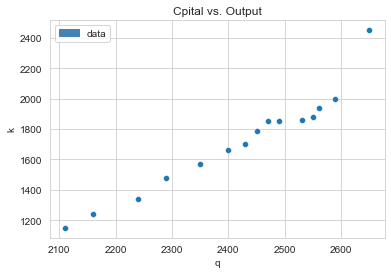

In [26]:
sns.scatterplot(x = df2.q, y = df2.k)
plt.title('Cpital vs. Output')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [blue_patch])
plt.savefig('3.png', dpi=300)

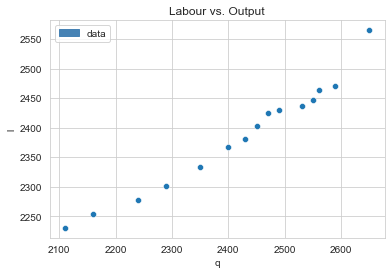

In [27]:
sns.scatterplot(x = df2.q, y = df2.l)
plt.title('Labour vs. Output')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [blue_patch])

In [28]:
print('Corr between labour and capital is : {} '.format(df2.l.corr(df2.k)))

Corr between labour and capital is : 0.9924905222087533 


In [29]:
X = np.array(np.log(df2.k)).reshape(-1, 1)
y = np.array(np.log(df2.q))
reg.fit(X, y)

LinearRegression()

In [30]:
intercept, slope = reg.intercept_, float(reg.coef_)
print('beta_0 = {} \nbeta_1 = {}'.format(intercept, slope))
print('R^2 = {} '.format(reg.score(X, y)))
print('y_hat = {} + {} * x'.format(intercept, slope))

beta_0 = 5.296623229980469 
beta_1 = 0.3353620171546936
R^2 = 0.9659081484585744 
y_hat = 5.296623229980469 + 0.3353620171546936 * x


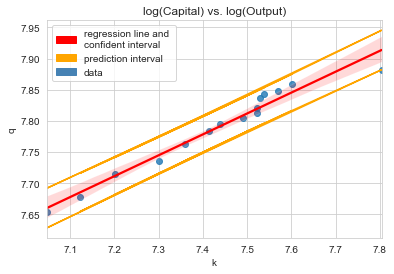

In [31]:
pred_int = LRPI()
pred_int.fit(np.log(df2.k), np.log(df2.q))
results = pred_int.predict(np.log(df2.k))

sns.regplot(x = np.log(df2.k), y = np.log(df2.q), line_kws = {'color': 'red'})
plt.title('log(Capital) vs. log(Output)')

red_patch = mpatches.Patch(color = 'red', label = 'regression line and \nconfident interval')
yellow_patch = mpatches.Patch(color = 'orange', label = 'prediction interval')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [red_patch, yellow_patch, blue_patch])

plt.plot(np.log(df2.k), results.lower, color = 'orange')
plt.plot(np.log(df2.k), results.upper, color = 'orange')

In [32]:
mean = np.mean(df2.k)
median = np.median(df2.k)

#### Elasticity = beta_1

In [33]:
# Computing ME for mean and median x
print('Marginal Effect of mean X is {} '.format(me_loglog(intercept, slope, mean)))
print('Marginal Effect of median X is {} '.format(me_loglog(intercept, slope, median)))

Marginal Effect of mean X is 66.95886981748914 
Marginal Effect of median X is 66.95886981748926 


In [34]:
pred_mean = reg.predict((np.log(mean)).reshape(-1,1))
print('Predicted value of y for mean X is {}'.format(float(pred_mean)))

pred_median = reg.predict((np.log(median)).reshape(-1,1))
print('Predicted value of y for median X is {}'.format(float(pred_median)))

Predicted value of y for mean X is 7.794576597890011
Predicted value of y for median X is 7.808474979043661


# # 4
Исследователю доступны данные о потреблении 869 домохозяйств в США в 1995 году (foodexp.dta). Он хочет оценить, как меняется потребление еды и безалкогольных напитков (fdho, долл. США) при изменении дохода домохозяйств (доступны данные об общих расходах домохозяйств expend, долл. США).

In [35]:
df3 = pd.read_stata('foodexp.dta')
df3.head(10)

,fdho,expend
0,6475,40516.750000
1,3146,33540.500000
2,1632,5181.850098
3,2405,40385.000000
4,2227,40302.250000
5,2470,23188.750000
6,3510,13503.450195
7,1662,5109.799805
8,2405,15753.500000
9,2483,40762.750000


In [36]:
pd.io.stata.StataReader('foodexp.dta').variable_labels()

{'fdho': 'Food expenditures', 'expend': 'Total expenditures'}

In [37]:
df3['lexpend'] = np.log(df3.expend)

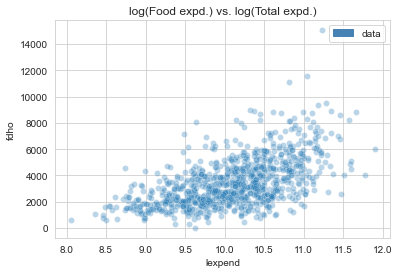

In [38]:
sns.scatterplot(x = df3.lexpend, y = df3.fdho, alpha = 0.3)
plt.title('log(Food expd.) vs. log(Total expd.)')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [blue_patch])

In [39]:
X = np.array(df3.lexpend).reshape(-1, 1)
y = np.array(df3.fdho)
reg.fit(X, y)

LinearRegression()

In [40]:
intercept, slope = reg.intercept_, float(reg.coef_)
print('beta_0 = {} \nbeta_1 = {}'.format(intercept, slope))
print('R^2 = {} '.format(reg.score(X, y)))
print('y_hat = {} + {} * x'.format(intercept, slope))

beta_0 = -12602.1484375 
beta_1 = 1593.0364990234375
R^2 = 0.31034819531196334 
y_hat = -12602.1484375 + 1593.0364990234375 * x


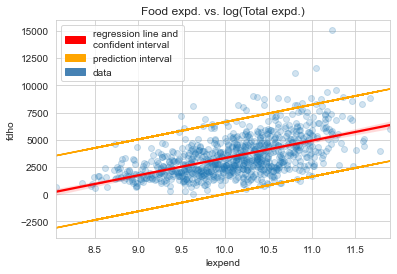

In [41]:
pred_int = LRPI()
pred_int.fit(df3.lexpend, df3.fdho)
results = pred_int.predict(df3.lexpend)

sns.regplot(x = df3.lexpend, y = df3.fdho, line_kws = {'color': 'red'}, scatter_kws = {'alpha': 0.2})
plt.title('Food expd. vs. log(Total expd.)')

red_patch = mpatches.Patch(color = 'red', label = 'regression line and \nconfident interval')
yellow_patch = mpatches.Patch(color = 'orange', label = 'prediction interval')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [red_patch, yellow_patch, blue_patch])

plt.plot(df3.lexpend, results.lower, color = 'orange')
plt.plot(df3.lexpend, results.upper, color = 'orange')

In [42]:
mean = np.mean(df3.expend)
median = np.median(df3.expend)

In [43]:
print('Elasticity of mean X is {} '.format(el_linlog(intercept, slope, mean)))
print('Elasticity of median X is {} '.format(el_linlog(intercept, slope, median)))

Elasticity of mean X is 0.0 
Elasticity of median X is 0.0 


<ipython-input-2-30926bb6b4fe>:10: RuntimeWarning: overflow encountered in exp
  el = beta1 / (np.exp(beta0 + beta1 * np.log(x)))


In [44]:
print('ME of mean X is {} '.format(me_linlog(slope, mean)))
print('ME of median X is {} '.format(me_linlog(slope, median)))

ME of mean X is 0.05322103325716359 
ME of median X is 0.06226983814271539 


In [45]:
pred_mean = reg.predict((np.log(mean)).reshape(-1,1))
print('Predicted value of y for mean X is {}'.format(float(pred_mean)))

pred_median = reg.predict((np.log(median)).reshape(-1,1))
print('Predicted value of y for median X is {}'.format(float(pred_median)))

Predicted value of y for mean X is 3816.798828125
Predicted value of y for median X is 3566.6552734375


# # 5
Исследователь оценивает зависимость рейтинга курсов среди студентов (course_eval) от внешней привлекательности (beauty) на датасете beauty.dta. 

In [46]:
df4 = pd.read_stata('beauty.dta')
df4.head(10)

,minority,age,female,onecredit,beauty,course_eval,intro,nnenglish
0,1,36,1,0,0.289916,4.3,0,0
1,0,59,0,0,-0.737732,4.5,0,0
2,0,51,0,0,-0.571984,3.7,0,0
3,0,40,1,0,-0.677963,4.3,0,0
4,0,31,1,0,1.509794,4.4,0,0
5,0,62,0,0,0.588569,4.2,0,0
6,0,33,1,0,-0.126001,4.0,0,0
7,0,51,1,0,-0.258190,3.4,0,0
8,0,33,1,0,0.149693,4.5,0,0
9,0,47,0,0,0.540917,3.9,0,0


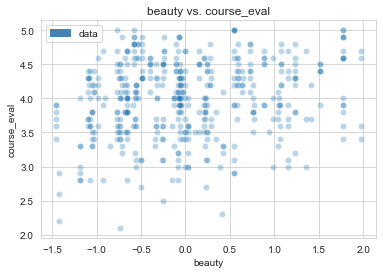

In [47]:
sns.scatterplot(x = df4.beauty, y = df4.course_eval, alpha=0.3)
plt.title('beauty vs. course_eval')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [blue_patch])

<AxesSubplot:xlabel='beauty', ylabel='course_eval'>

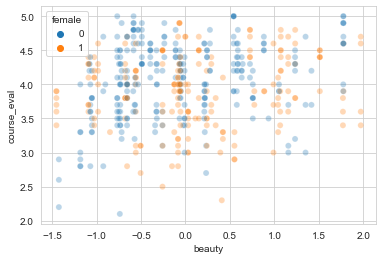

In [48]:
sns.scatterplot(data=df4, x="beauty", y="course_eval", hue="female", alpha=0.3)

In [49]:
X = np.array(df4.beauty).reshape(-1, 1)
y = np.array(df4.course_eval)
reg.fit(X, y)

LinearRegression()

In [50]:
intercept, slope = reg.intercept_, float(reg.coef_)
print('beta_0 = {} \nbeta_1 = {}'.format(intercept, slope))
print('R^2 = {} '.format(reg.score(X, y)))
print('y_hat = {} + {} * x'.format(intercept, slope))

beta_0 = 3.998272180557251 
beta_1 = 0.133001446723938
R^2 = 0.03573576706245141 
y_hat = 3.998272180557251 + 0.133001446723938 * x


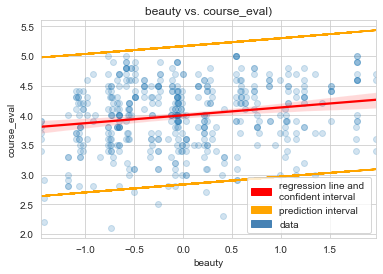

In [51]:
pred_int = LRPI()
pred_int.fit(df4.beauty, df4.course_eval)
results = pred_int.predict(df4.beauty)

sns.regplot(x = df4.beauty, y = df4.course_eval, line_kws = {'color': 'red'}, scatter_kws = {'alpha': 0.2})
plt.title('beauty vs. course_eval)')

red_patch = mpatches.Patch(color = 'red', label = 'regression line and \nconfident interval')
yellow_patch = mpatches.Patch(color = 'orange', label = 'prediction interval')
blue_patch = mpatches.Patch(color = 'steelblue', label = 'data')
plt.legend(handles = [red_patch, yellow_patch, blue_patch])

plt.plot(df4.beauty, results.lower, color = 'orange')
plt.plot(df4.beauty, results.upper, color = 'orange')
plt.savefig('5.png', dpi=300)

In [52]:
mean = np.mean(X)
median = np.median(X)

In [53]:
print('Elasticity of mean X is {} '.format(el_linlin(intercept, slope, mean)))
print('Elasticity of median X is {} '.format(el_linlin(intercept, slope, median)))

Elasticity of mean X is 2.192567999453204e-09 
Elasticity of median X is -0.0022676078192622835 


#### ME is const for linlin

In [54]:
pred_mean = reg.predict((mean).reshape(-1,1))
print('Predicted value of y for mean X is {}'.format(float(pred_mean)))

pred_median = reg.predict((median).reshape(-1,1))
print('Predicted value of y for median X is {}'.format(float(pred_median)))

Predicted value of y for mean X is 3.998272180557251
Predicted value of y for median X is 3.9892261028289795
